In [14]:
#########################
# Example for using fermionic operators
# in the VMC framework
#########################

# VMC
import jVMC
import jVMC.nets as nets
import jVMC.operator as op
from jVMC.operator import number, creation, annihilation
import jVMC.sampler
from jVMC.util import ground_state_search, measure
from jVMC.vqs import NQS
from jVMC.stats import SampledObs
from jVMC import global_defs

# python stuff
import functools

# jax
import jax
from jax.config import config
config.update("jax_enable_x64", True)
import jax.numpy as jnp
import flax.linen as nn

import jax.random as random

# numpy
import numpy as np

# plotting
import matplotlib.pyplot as plt

#########################
# check against openfermion
#########################

import openfermion as of
from openfermion.ops import FermionOperator as fop
from openfermion.linalg import get_sparse_operator

In [15]:
##########################
# custon tarbget wave function
# specific to openfermion compatibility
class Target(nn.Module):
  """Target wave function, returns a vector with the same dimension as the Hilbert space

    Initialization arguments:
        * ``L``: System size
        * ``d``: local Hilbert space dimension
        * ``delta``: small number to avoid log(0)

    """
  L: int
  d: float = 2.00
  delta: float = 1e-15

  @nn.compact
  def __call__(self, s):
    kernel = self.param('kernel',
                        nn.initializers.constant(1),
                        (int(self.d**self.L)))
    # return amplitude for state s
    idx = ((self.d**jnp.arange(self.L)).dot(s[::-1])).astype(int) # NOTE that the state is reversed to account for different bit conventions used in openfermion
    return jnp.log(abs(kernel[idx]+self.delta)) + 1.j*jnp.angle(kernel[idx]) 

## Fermionic operators

Fermionic operators have to satisfy the following condition
$$
\lbrace \hat{c}^\dagger_i, \hat{c}_j\rbrace  = \delta_{ij} \; ,
$$
where $i,j$ are so-called *flavours*.As is done in 'openfermoin' we do not allow for a spin quantum number. In other words, all our fermionic operators can only carry a single flavour. For higher flavour indeces one has combine several distinct fermionis.

The key to realizing fermions is the Jordan-Wigner factor. Every fermionic state is constructed using a filling order, then we have to count how many craetion operatros a given operator has to commute thorugh to arrive at his filling order position.
We can achieve this as follows.
$$
\hat{c}^\dagger\vert 1, 0 \rangle = (-1)^\Omega \vert 1,1\rangle
$$
with 
$$
\Omega = \sum^{j-1}_{i=0} s_i \; .
$$
In the following we construct Andersons impurity model Hamiltonian as an example and compare it to openfermion
$$
H = U \hat{n}_{d\uparrow}\hat{n}_{d\downarrow} - \tfrac{U}{2}(\hat{n}_{d\uparrow}+\hat{n}_{d\downarrow}) + V\sum_\sigma \hat{d}^\dagger_\sigma \hat{c}_{\sigma 0} + h.c. + \sum_i t_i \hat{c}^\dagger_{\sigma i} \hat{c}_{\sigma i+1} + h.c. \;.
$$ 

In [16]:
def wilson_chain(Lam):
    def wilson_t(i):
      # note that that the wilson chain is indexed from 0
      # note that we added the exponential decay factor
      return .5*(1.+Lam**(-1.))*(1.-Lam**(-i-1.))*((1.-Lam**(-2.*i-1.))*(1.-Lam**(-2.*i-3.)))**(-.5) * Lam**(-0.5*i)
    return wilson_t

In [17]:
# wilson chain
lmbda = 3.
alambda = (lmbda+1.)/(lmbda-1.)*np.log(lmbda)/2.
wt = wilson_chain(lmbda)
# impurity parameters?
U = 0.3
V = 0.12
N = 3

In [18]:
#########################
# openfermion
#########################
L = 2*N + 2
# number of fermions
N_f = L//2
##########################
# building the Anderson Impurity Hamiltonian
##########################
impUP = 0
impDO = L//2
H = U*fop(((impUP,1),(impUP,0),(impDO,1),(impDO,0))) + fop(((impUP,1),(impUP,0)),- 0.5*U) + fop(((impDO,1),(impDO,0)),- 0.5*U)
site2UP = 1
H += fop(((site2UP,1),(impUP,0)),V*np.sqrt(alambda)) + fop(((impUP,1),(site2UP,0)),V*np.sqrt(alambda))
site2DO = L//2 + 1
H += fop(((site2DO,1),(impDO,0)),V*np.sqrt(alambda)) + fop(((impDO,1),(site2DO,0)),V*np.sqrt(alambda))
for i in range(0,L//2-2):
    # up chain
    H -= (fop(((site2UP + i,1),(site2UP + i + 1,0)),wt(i)) + fop(((site2UP + i + 1,1),(site2UP + i,0)),wt(i)))
    # down chain
    H -= (fop(((site2DO + i,1),(site2DO + i + 1,0)),wt(i)) + fop(((site2DO + i + 1,1),(site2DO + i,0)),wt(i)))

In [19]:
#########################
# diagonalize the Openfermion Hamiltonain
#########################

ham = get_sparse_operator(H)
a, b = np.linalg.eigh(ham.toarray())

chi_model = Target(L=L, d=2)
chi = NQS(chi_model)
chi(jnp.array(jnp.ones((1, 1, L))))
chi.set_parameters(b[:,0]+1e-14)
chiSampler = jVMC.sampler.ExactSampler(chi, (L,))

In [20]:
#########################
# jVMC hamiltonian
#########################

# initalize the Hamitonian
hamiltonian = op.BranchFreeOperator()
# impurity definitions
impUP = 0
impDO = L//2
# hubbard interaction
hamiltonian.add(op.scal_opstr( U, ( number(impUP) , number(impDO) ) ) )
# impurity chemical potential
hamiltonian.add(op.scal_opstr( - 0.5*U , ( number(impUP) ,) ) )
hamiltonian.add(op.scal_opstr( - 0.5*U , ( number(impDO) ,) ) )
# hybridization
site2UP = 1
hamiltonian.add(op.scal_opstr( V*np.sqrt(alambda), ( annihilation(impUP) ,creation(site2UP)  ) ) )
hamiltonian.add(op.scal_opstr( V*np.sqrt(alambda), ( annihilation(site2UP) ,creation(impUP)  ) ) )
site2DO = L//2 + 1
hamiltonian.add(op.scal_opstr( V*np.sqrt(alambda), ( annihilation(impDO) ,creation(site2DO)  ) ) )
hamiltonian.add(op.scal_opstr( V*np.sqrt(alambda), ( annihilation(site2DO) ,creation(impDO)  ) ) )
for i in range(0,L//2-2):
    # up chain
    hamiltonian.add(op.scal_opstr( -1.*wt(i), ( annihilation(site2UP + i) ,creation(site2UP + i + 1)  ) ) )
    hamiltonian.add(op.scal_opstr( -1.*wt(i), ( annihilation(site2UP + i + 1) ,creation(site2UP + i)  ) ) )
    # down chain
    hamiltonian.add(op.scal_opstr( -1.*wt(i), ( annihilation(site2DO + i) ,creation(site2DO + i + 1)  ) ) )
    hamiltonian.add(op.scal_opstr( -1.*wt(i), ( annihilation(site2DO + i + 1) ,creation(site2DO + i)  ) ) )

In [24]:
s, logPsi, p = chiSampler.sample()
sPrime, _ = hamiltonian.get_s_primes(s)
Oloc = hamiltonian.get_O_loc(s, chi, logPsi)
Omean = jVMC.mpi_wrapper.global_mean(Oloc,p)

print("Ground state energy: \njVMC: %.8f, Openfermion: %.8f"%(Omean.real,a[0]))

Ground state energy: 
jVMC: -1.55428401, Openfermion: -1.55428401


### Finding the ground state brute force

In [25]:
# Set up variational wave function
all_states = nets.Target(L=L, d=2)#nets.CpxRBM(numHidden=2**6, bias=True)
psi = NQS(all_states)
# initialize NQS
print("Net init: ",psi(jnp.array(jnp.ones((1, 1, L)))))
# Set up exact sampler
exactSampler = jVMC.sampler.ExactSampler(psi, L)

Net init:  [[1.11022302e-15+0.j]]


0 -1.5534376096310791 4.652372719686978e-05
1 -1.5534418377118129 4.6289929982710256e-05
2 -1.5534460445264604 4.605730697335468e-05
3 -1.553450230182005 4.582585239011497e-05
4 -1.553454394784907 4.5595560480750366e-05
5 -1.5534585384410984 4.536642551937233e-05
6 -1.5534626612559883 4.5138441806349345e-05
7 -1.5534667633344605 4.4911603668212874e-05
8 -1.5534708447808865 4.468590545756262e-05
9 -1.55347490569912 4.446134155297134e-05
10 -1.5534789461924976 4.423790635889209e-05
11 -1.5534829663638472 4.4015594305561216e-05
12 -1.553486966315487 4.379439984890532e-05
13 -1.5534909461492328 4.357431747044655e-05
14 -1.5534949059663852 4.335534167720822e-05
15 -1.5534988458677534 4.313746700162002e-05
16 -1.553502765953644 4.2920688001424416e-05
17 -1.5535066663238633 4.270499925958116e-05
18 -1.5535105470777264 4.2490395384174424e-05
19 -1.5535144083140506 4.2276871008317514e-05
20 -1.5535182501311713 4.206442079005959e-05
21 -1.5535220726269277 4.185303941229121e-05
22 -1.553525875898

Text(0.5, 0, 'iteration')

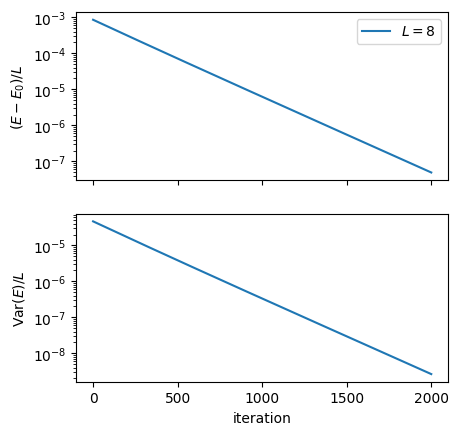

In [30]:
# Set up sampler
sampler = jVMC.sampler.ExactSampler(psi, L)

# Set up TDVP
tdvpEquation = jVMC.util.tdvp.TDVP(sampler, rhsPrefactor=1.,
                                   svdTol=1e-8, diagonalShift=10, makeReal='real')

stepper = jVMC.util.stepper.Euler(timeStep=5e-1)  # ODE integrator

n_steps = 2000
res = []
for n in range(n_steps):

    dp, _ = stepper.step(0, tdvpEquation, psi.get_parameters(), hamiltonian=hamiltonian, psi=psi, numSamples=None)
    psi.set_parameters(dp)

    print(n, jax.numpy.real(tdvpEquation.ElocMean0), tdvpEquation.ElocVar0)

    res.append([n, jax.numpy.real(tdvpEquation.ElocMean0), tdvpEquation.ElocVar0])

res = np.array(res)

fig, ax = plt.subplots(2, 1, sharex=True, figsize=[4.8, 4.8])
ax[0].semilogy(res[:, 0], res[:, 1] - a[0], '-', label=r"$L=" + str(L) + "$")
ax[0].set_ylabel(r'$(E-E_0)/L$')

ax[1].semilogy(res[:, 0], res[:, 2], '-')
ax[1].set_ylabel(r'Var$(E)/L$')
ax[0].legend()
plt.xlabel('iteration')

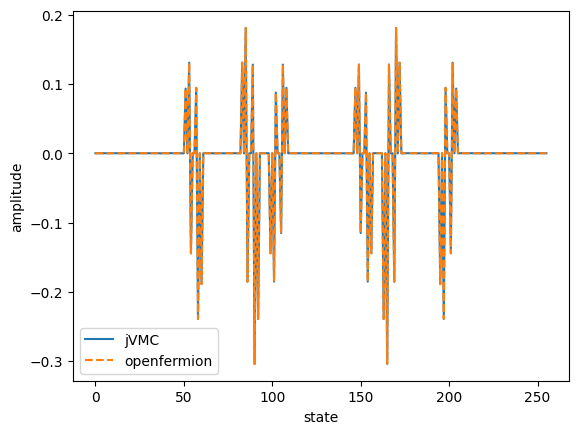

In [31]:
s, logPsi, _ = exactSampler.sample()
var_wf = np.real(np.exp(logPsi))[0]
# normalizing the wave function
var_wf /= var_wf.dot(var_wf)**0.5

figure = plt.figure(dpi=100)
plt.xlabel('state')
plt.ylabel('amplitude')
plt.plot(-var_wf,label='jVMC')
plt.plot(np.exp(chi(s)).real[0],'--',label='openfermion')
plt.legend()